Kimberly Adams

Spring 2024

# Bird Photo Identification

*In this project, I will build a convolutional neural network (CNN) to identify the species of bird shown in a photo.*

In [1]:
# Import usual libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import seaborn as sns

In [2]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import special libraries
import os
import random
import tensorflow as tf

2024-04-28 17:11:28.914274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 20 Species

In [4]:
# Load the data
data_train = '20Species/train'
data_test = '20Species/test'
data_valid = '20Species/valid'

In [5]:
# Count images in each folder
def CountImages(ImagesFolder):
    ClassCounts = {}
    for FolderName in os.listdir(ImagesFolder):
        FolderPath = os.path.join(ImagesFolder, FolderName)
        if os.path.isdir(FolderPath):
            ImageCount = len([filename for filename in os.listdir(FolderPath) if filename.endswith(('.jpg', '.jpeg', '.png'))])
            ClassCounts[FolderName] = ImageCount
    return ClassCounts

In [6]:
# Print the image distribution in each folder
def plot_bar_graph(ClassCounts, name):
    labels = list(ClassCounts.keys())
    counts = list(ClassCounts.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    plt.xlabel('Species')
    plt.ylabel('Number of Images')
    plt.title(f'Images in {name}')
    plt.xticks(rotation=90)
    plt.show()

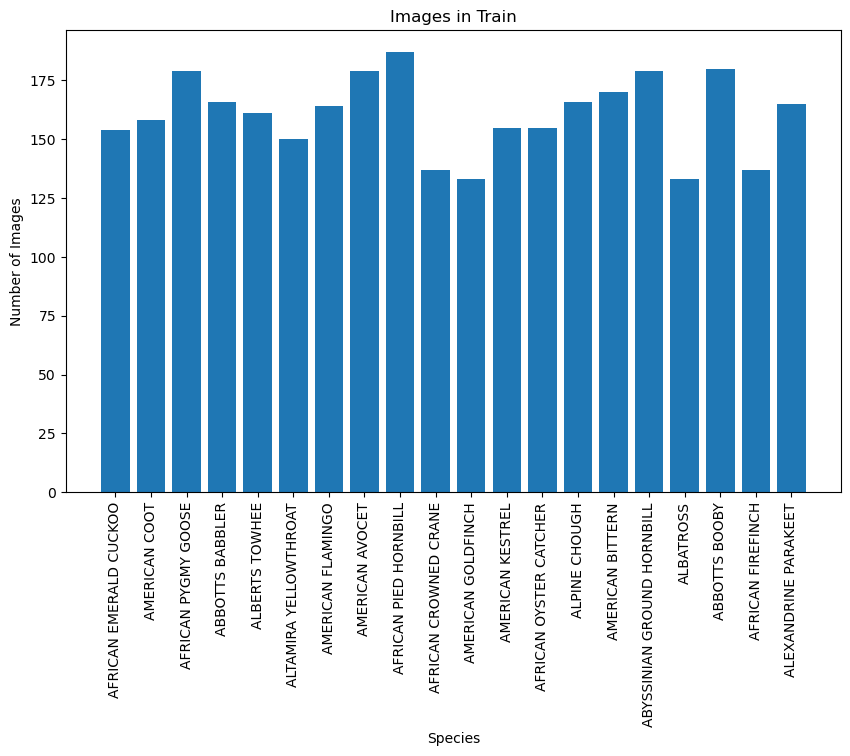

In [7]:
ClassCounts = CountImages('20Species/train')
plot_bar_graph(ClassCounts, 'Train')

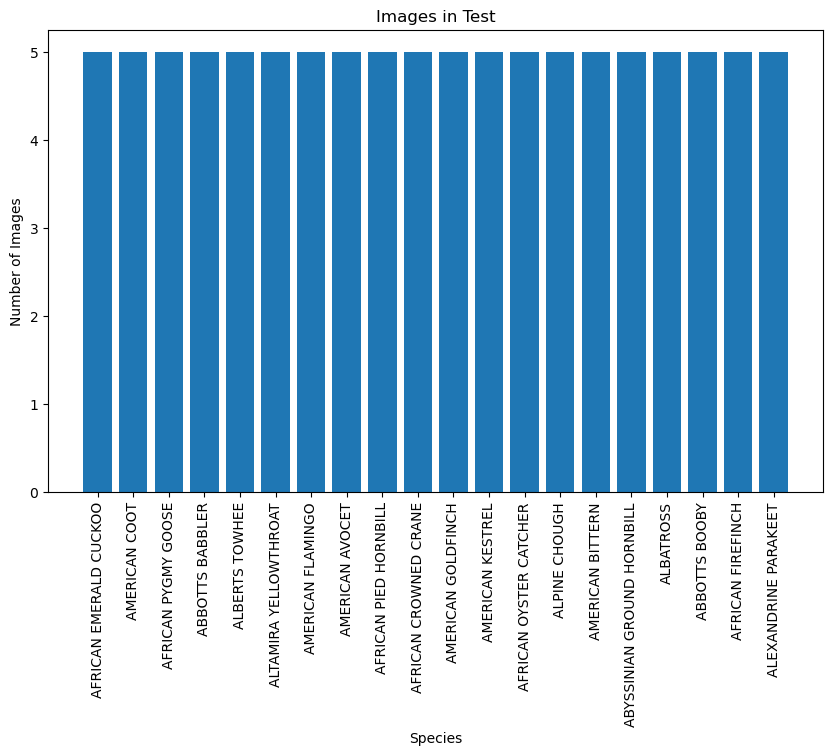

In [9]:
ClassCounts = CountImages('20Species/test')
plot_bar_graph(ClassCounts, 'Test')

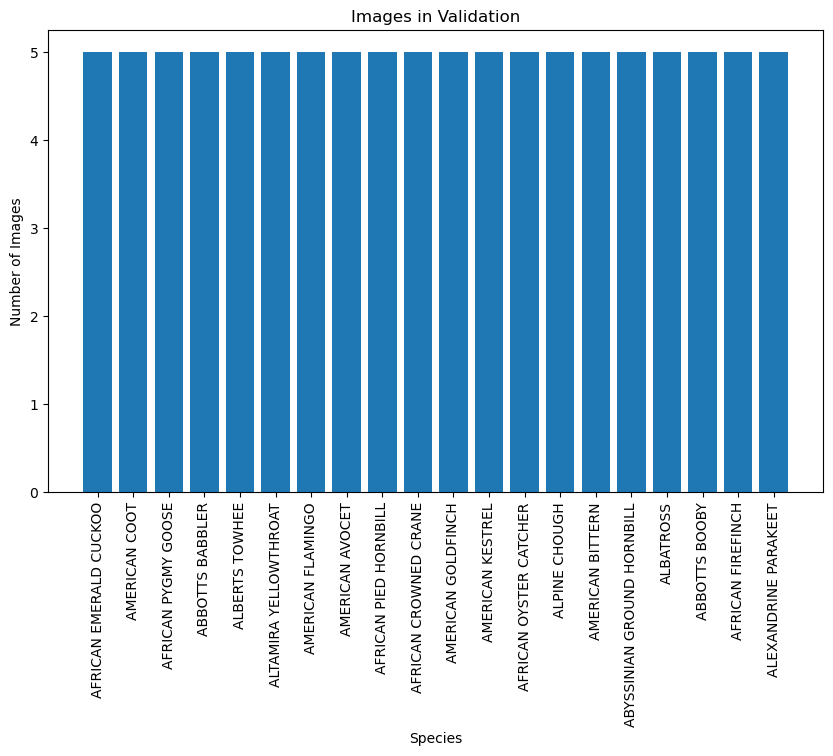

In [10]:
ClassCounts = CountImages('20Species/valid')
plot_bar_graph(ClassCounts, 'Validation')

In [11]:
# Display random images from the training dataset
def DisplayImages(directory, NumImages=5):
    images = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):
                images.append(os.path.join(root, file))
    RandomImages = random.sample(images, NumImages) # Select random images

    # Plot the images
    fig, axes = plt.subplots(1, NumImages, figsize=(15, 3))
    for i, ImagePath in enumerate(RandomImages):
        img = mpimg.imread(ImagePath)
        Subfolder = os.path.basename(os.path.dirname(ImagePath))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(Subfolder)
    plt.show()

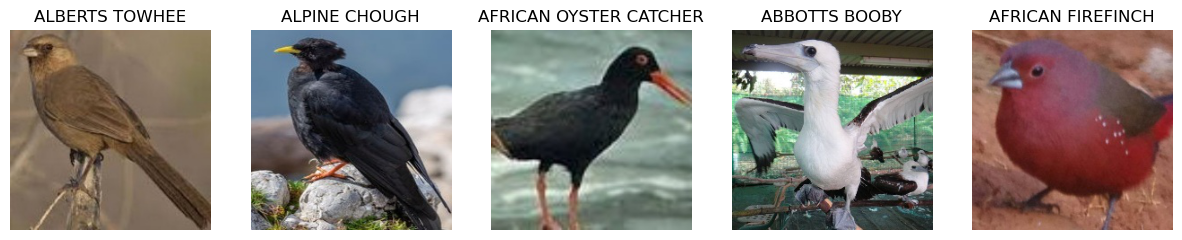

In [12]:
# Display 5 random images
DisplayImages('20Species/train', NumImages=5)

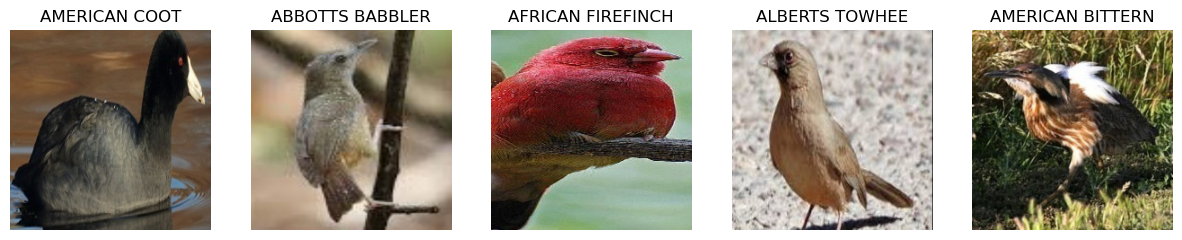

In [13]:
# Display another 5 random images
DisplayImages('20Species/train', NumImages=5)

In [14]:
# Import needed library tool
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data loaders, but apply augmentation only for the training set
# Rescale pixel intensity to between 0 and 1

ImageShape = (224,224)
Batch = 32
tf.random.set_seed(42)

train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)


train_data_augmented = train_datagen_augmented.flow_from_directory(data_train,
                                              target_size = ImageShape,
                                              class_mode='categorical',
                                              batch_size=Batch,
                                              shuffle=True,
                                              seed = 42)

valid_data = valid_datagen.flow_from_directory(data_valid,
                                              target_size = ImageShape,
                                              class_mode='categorical',
                                              batch_size=Batch,
                                              shuffle=True,
                                              seed = 42)

test_data = test_datagen.flow_from_directory(data_test,
                                              target_size = ImageShape,
                                              class_mode='categorical',
                                              batch_size=Batch,
                                              shuffle=False)

Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


In [15]:
len(train_data_augmented), len(valid_data)

(101, 4)

In [16]:
# List out the classes (species)
classes = list(train_data_augmented.class_indices.keys())
ClassesCount = len(classes)
classes

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL']

In [17]:
# Start neural network sequential model
model= tf.keras.Sequential([
    # Add convolutional and max pooling layers with various filter sizes, shrinking window sizes, and ReLu activation function
    tf.keras.layers.Conv2D(64, (11, 11), strides=(4, 4), padding='same', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    tf.keras.layers.Conv2D(192, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    tf.keras.layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    
    # Add fully connected layers with ReLu and softmax activation functions
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(ClassesCount, activation='softmax')])

In [18]:
# Compile neural network model
model.compile(loss="categorical_crossentropy", # Cross-entropy
                optimizer="rmsprop", # Root Mean Square Propagation
                metrics=["accuracy"]) # Accuracy performance metric

In [19]:
# Fit neural network model to training data
progress = model.fit(train_data_augmented, # Features
            epochs=20, # Number of epochs
            #verbose=0, # Don't print description after each epoch
            batch_size=200, # Number of observations per batch
            validation_data=valid_data) # Data for evaluation

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 92s 855ms/step - accuracy: 0.0558 - loss: 3.6690 - val_accuracy: 0.0500 - val_loss: 2.9961
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 89s 845ms/step - accuracy: 0.0508 - loss: 3.0041 - val_accuracy: 0.0900 - val_loss: 2.9681
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 88s 832ms/step - accuracy: 0.0545 - loss: 3.0398 - val_accuracy: 0.1000 - val_loss: 2.7431
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 90s 851ms/step - accuracy: 0.0914 - loss: 2.9472 - val_accuracy: 0.1200 - val_loss: 2.6516
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 89s 841ms/step - accuracy: 0.1356 - loss: 2.7310 - val_accuracy: 0.2100 - val_loss: 2.4896
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 87s 827ms/step - accuracy: 0.1571 - loss: 2.5864 - val_accuracy: 0.2200 - val_loss: 2.4394
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 88s 842ms/step - accuracy: 0.2276 - loss: 2.4259 - val_accuracy: 0.2300 - val_loss: 2.3241
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 89s 847ms/step - accuracy: 0.2535 - loss: 2

In [20]:
# Calculate and print model accuracy
_, acc = model.evaluate(valid_data, verbose=0)
print('Accuracy Score = ', (acc*100), '%')

Accuracy Score =  68.99999976158142 %


Text(0, 0.5, 'Score')

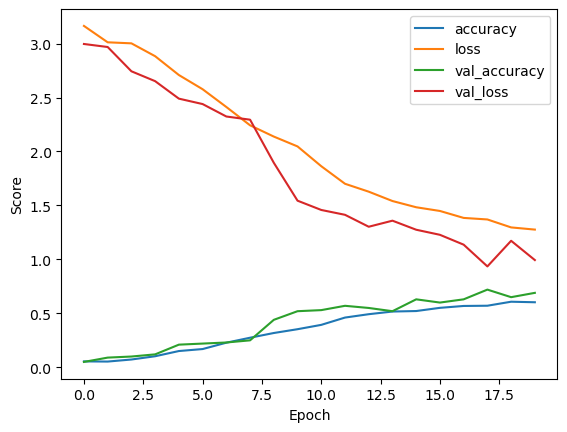

In [27]:
pd.DataFrame(progress.history).plot()
plt.xlabel('Epoch')
plt.ylabel('Score')

In [22]:
# Analyse the performance of the model on the test images
train_evaluation = model.evaluate(train_data_augmented)
train_accuracy = train_evaluation[1]
train_loss = train_evaluation[0]


valid_evaluation = model.evaluate(valid_data)
valid_accuracy = valid_evaluation[1]
valid_loss = valid_evaluation[0]


test_evaluation = model.evaluate(test_data)
test_accuracy = test_evaluation[1]
test_loss = test_evaluation[0]

# Generate a table
from tabulate import tabulate

data = [
    ["Training", train_accuracy, train_loss],
    ["Validation", valid_accuracy, valid_loss],
    ["Test", test_accuracy, test_loss]
]

headers = ["Dataset", "Accuracy", "Loss"]

table = tabulate(data, headers=headers, tablefmt="grid")

print(table)

101/101 ━━━━━━━━━━━━━━━━━━━━ 61s 597ms/step - accuracy: 0.5944 - loss: 1.2475
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.6895 - loss: 1.0219
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7693 - loss: 0.7451
+------------+------------+----------+
| Dataset    |   Accuracy |     Loss |
+============+============+==========+
| Training   |   0.599439 | 1.24583  |
+------------+------------+----------+
| Validation |   0.69     | 0.993831 |
+------------+------------+----------+
| Test       |   0.78     | 0.745995 |
+------------+------------+----------+


In [23]:
test_predictions = model.predict(test_data)
test_predictions = np.argmax(test_predictions, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


<Axes: >

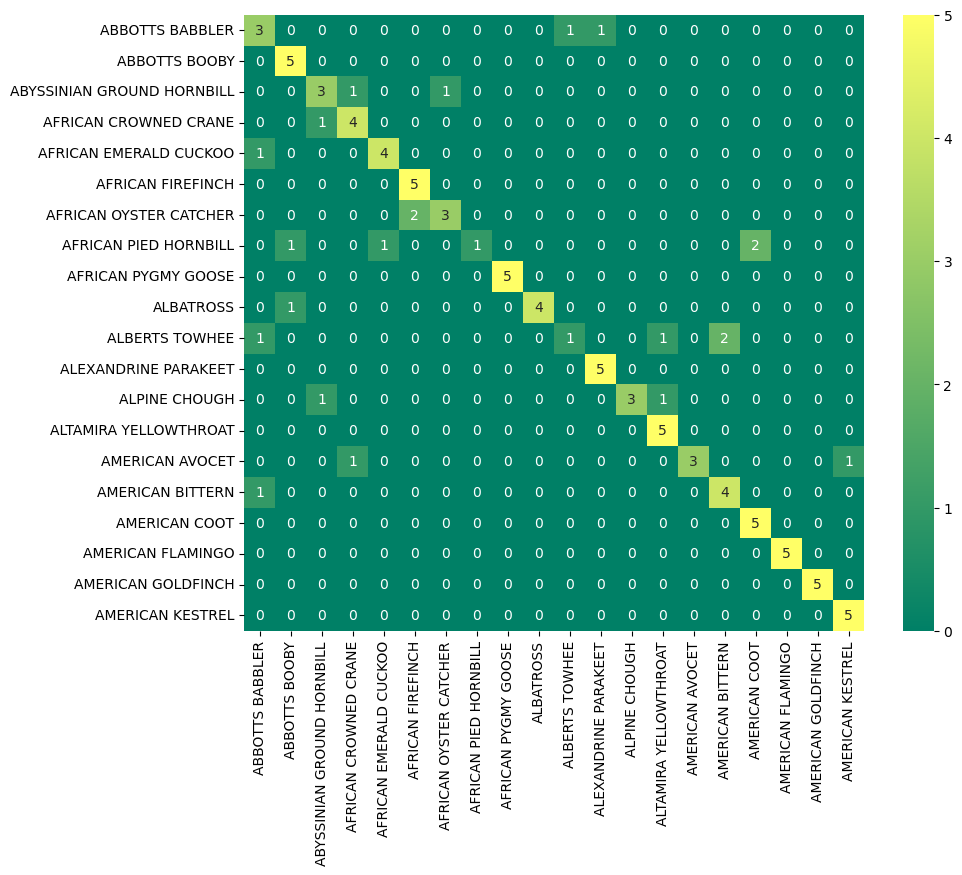

In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = test_data.classes
y_pred = test_predictions
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='summer', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())

In [25]:
# Use the model to predict for the given test images
def predict_images(directory):
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory)]
    num_images = len(image_paths)
    
    images = []
    predictions = []
    
    for image_path in image_paths:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, (224, 224))
        image = image / 255.0
        images.append(image)
    
    images = np.array(images)
    
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    plt.figure(figsize = (20,20))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(classes[predicted_classes[i]])
        plt.axis(False)
        
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


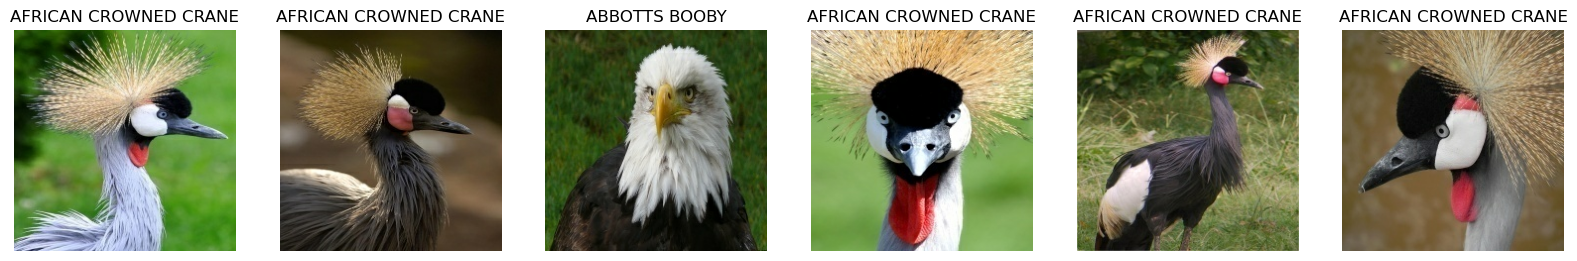

In [26]:
predict_images('20Species/images to predict')

https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/